In [1]:
#region imports
import pandas as pd
import numpy as np
import missingno as msno
import random
import re
from nltk import word_tokenize
import re
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
stop_words = nltk.corpus.stopwords.words("english")
lemmatizer = WordNetLemmatizer()
from sklearn.feature_extraction.text import CountVectorizer


RANDOMSEED = 100
DISPLAY_WIDTH = 400
DISPLAYMAX_COLUMNS = 25
#endregion

#region settings
random.seed(RANDOMSEED)
pd.set_option('display.width', DISPLAY_WIDTH)
pd.set_option('display.max_columns', DISPLAYMAX_COLUMNS)
#endregion

In [2]:
df_awards=pd.read_csv("../data/220k_awards_by_directors.csv")
df_500_fav=pd.read_csv("../data/500 favorite directors_with wikipedia summary.csv", sep=";",header=0,names=['A', 'B'])
df_900_acc=pd.read_csv("../data/900_acclaimed_directors_awards.csv", sep=";")
df_all_casting=pd.read_csv("../data/AllMoviesCastingRaw.csv", sep=";")
df_all_details = pd.read_csv("../data/AllMoviesDetailsCleaned.csv", sep=";",low_memory=False)
df_lan2country_df = pd.read_csv('../data/language to country.csv')
df_most_common_lang=pd.read_csv("../data/MostCommonLanguageByDirector.csv")
df_spliberg=pd.read_csv("../data/spielberg_awards.csv",encoding='latin1')

In [3]:
def show(df_, rows=20, cols=30, title=None):
    if title:
        display(HTML(f'<h2 >{title}</h2 > '))
        with pd.option_context('display.min_rows', rows, 'display.max_columns', cols):
            display(df_)
    return df_

def get_var(df, var_name):
    globals()[var_name] = df
    return df

def tokenize(text):
    '''this method does the following
    1. normalizing all the words to lower size
    2. removes punctuations
    3. splits the words
    4. removes the stopwords like am,is,have,you,...
    5. lammetizes the words for example running-->run
    '''
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())    # normalize case and remove punctuation
    tokens = word_tokenize(text)    # tokenize text
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]    # lemmatize andremove stop words
    return tokens

def prep_data(text,method=CountVectorizer):
    '''
    this method counts either counts the words 
    in sentences (CountVectorizer) or wights them 
    based on their importance in the sentence 
    and entire data(TfidfVectorizer):
    '''
    count_vector = method(tokenizer=tokenize)
    count_vector.fit(text)
    doc_array = count_vector.transform(text).toarray()
    frequency_matrix_count = pd.DataFrame(doc_array, columns=count_vector.get_feature_names_out())
    return frequency_matrix_count



In [59]:
df=    (#1- major cleanups
    df_all_details  
        .query("status in ['Released']")
        .pipe(lambda df_:df_.replace("none",np.NaN))
        .assign(revenue=lambda df_:df_.revenue.replace(0,np.NAN),
            genres=lambda df_:df_.genres.fillna("none"),
            runtime=lambda df_:df_.runtime.fillna(-999),
            original_language=lambda df_:df_.original_language.fillna("none"),
            day_of_week_temp=lambda df_:pd.to_datetime(df_.release_date,dayfirst=True),
            day_of_week=lambda f_:f_.day_of_week_temp.apply( lambda d:d.weekday()),
            year=lambda df_:pd.to_datetime(df_.release_date,dayfirst=True).dt.year,
            age=lambda df_:(2025-pd.to_datetime(df_.release_date,dayfirst=True).dt.year).fillna(-999),
            month=lambda df_:(pd.to_datetime(df_.release_date,dayfirst=True).dt.month),
            sin_month=lambda df_:(np.sin(2*np.pi*(df_.month-1)/12)).fillna(-999),
            cos_month=lambda df_:(np.cos(2*np.pi*(df_.month-1)/12)).fillna(-999),
            
            )

        .dropna(subset="revenue")
        .reset_index(drop=True)
        .pipe(lambda df_:pd.concat([df_,
                                prep_data(df_.genres)],axis=1))
        .drop(columns=["imdb_id","original_title",
                    "overview","popularity","status","tagline","title","vote_average","vote_count",
                    "production_companies",	"production_countries","spoken_languages","release_date","day_of_week_temp"])
    
    )
actors_df=(
            df_all_casting #2- extracting actor_weights
                .melt(id_vars="id",value_vars=["actor1_name","actor2_name","actor3_name","actor4_name","actor5_name"])
                .sort_values(by=["id","variable"])
                .merge(df[["id","year"]],on="id",how="left")
                .replace("none",np.NaN)
                .dropna()
                .assign(unit=1)
                .sort_values(by=["value","year"])
                .assign(actor_freq=lambda df_:df_.groupby("value").cumsum()["unit"])
                .pipe(lambda df_:pd.pivot(df_,values="actor_freq",columns="variable",index="id"))
                .reset_index()
            )
director_df=(
    df_all_casting #2- extracting director_weights
                .melt(id_vars="id",value_vars=["director_name"])
                .sort_values(by=["id","variable"])
                .merge(df[["id","year"]],on="id",how="left")
                .replace("NaN",np.NaN)
                .replace("none",np.NaN)
                .dropna()
                .assign(unit=1)
                .sort_values(by=["value","year"])
                .assign(director_freq=lambda df_:df_.groupby("value").cumsum()["unit"])
                .drop(columns=["variable","value","year","unit"])
                .merge(df_all_casting[["id","director_name"]],on="id",how="left")
)

data_awards_cleaned=(df_awards
 .assign(outcome=lambda df_:df_["outcome"].replace(["2nd place", "3rd place"], "Won"))
 .groupby(["director_name", "year","outcome"])
 .count()
 .unstack()
 .fillna(0)
 .reset_index()
 .iloc[:,0:4]
 .pipe(lambda df_:pd.DataFrame(df_.values,columns=["director_name","year","nominated","won"]))
 .assign(nominated_cumsum = lambda df_: df_.groupby("director_name")["nominated"].transform(pd.Series.cumsum),
    won_cumsum = lambda df_: df_.groupby("director_name")["won"].transform(pd.Series.cumsum),
    )
 .set_index(["director_name","year"])
)
    

def fame_func(director,dt_,stat=0):

    try: 
        if stat==0:
            return data_awards_cleaned.loc[director][data_awards_cleaned.loc[director].index<=dt_].tail(1).nominated_cumsum.values[0]
        else:
            return data_awards_cleaned.loc[director][data_awards_cleaned.loc[director].index<=dt_].tail(1).won_cumsum.values[0]
            
    except:
        return np.NaN

df=(df
    .merge(actors_df,on=['id'],how="left")
    .merge(director_df,on=['id'],how="left")
    .drop(columns=["id","genres","original_language","spoken_languages_number"] )
).assign(
    fame_nominated= lambda df_:df_.apply(lambda df_:fame_func(df_.director_name,df_.year),axis=1),
    fame_won= lambda df_:df_.apply(lambda df_:fame_func(df_.director_name,df_.year,stat=1),axis=1)
    
)

df

/home/ashamsa/.pyenv/versions/.pde_cap/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,revenue,runtime,production_companies_number,production_countries_number,day_of_week,year,age,month,sin_month,cos_month,action,adventure,...,tv,war,western,actor1_name,actor2_name,actor3_name,actor4_name,actor5_name,director_freq,director_name,fame_nominated,fame_won
0,4300000.0,98.0,2,1,0.0,1995.0,30.0,12.0,-5.000000e-01,8.660254e-01,0,0,...,0,0,0,3.0,8.0,5.0,7.0,3.0,2.0,Allison Anders,4.0,4.0
1,12136938.0,110.0,3,2,4.0,1993.0,32.0,10.0,-1.000000e+00,-1.836970e-16,1,0,...,0,0,0,8.0,3.0,1.0,1.0,1.0,3.0,Stephen Hopkins,2.0,1.0
2,775398007.0,121.0,2,1,2.0,1977.0,48.0,5.0,8.660254e-01,-5.000000e-01,1,1,...,0,0,0,1.0,3.0,1.0,2.0,6.0,3.0,George Lucas,6.0,3.0
3,940335536.0,100.0,1,1,4.0,2003.0,22.0,5.0,8.660254e-01,-5.000000e-01,0,0,...,0,0,0,4.0,1.0,1.0,19.0,1.0,2.0,Andrew Stanton,9.0,8.0
4,677945399.0,142.0,1,1,2.0,1994.0,31.0,7.0,1.224647e-16,-1.000000e+00,0,0,...,0,0,0,14.0,3.0,2.0,3.0,13.0,8.0,Robert Zemeckis,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8653,200.0,-999.0,1,1,0.0,2017.0,8.0,6.0,5.000000e-01,-8.660254e-01,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,1.0,Fernando J Carasa,NaN,NaN
8654,700.0,10.0,1,3,0.0,2016.0,9.0,6.0,5.000000e-01,-8.660254e-01,0,0,...,0,0,0,NaN,1.0,1.0,NaN,NaN,1.0,Rohit Shivdas,NaN,NaN
8655,40000.0,-999.0,0,1,NaN,NaN,-999.0,NaN,-9.990000e+02,-9.990000e+02,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8656,640691.0,108.0,3,1,3.0,2016.0,9.0,12.0,-5.000000e-01,8.660254e-01,1,1,...,0,0,0,NaN,NaN,1.0,2.0,2.0,2.0,Sharmeen Obaid-Chinoy,5.0,17.0


<AxesSubplot:>

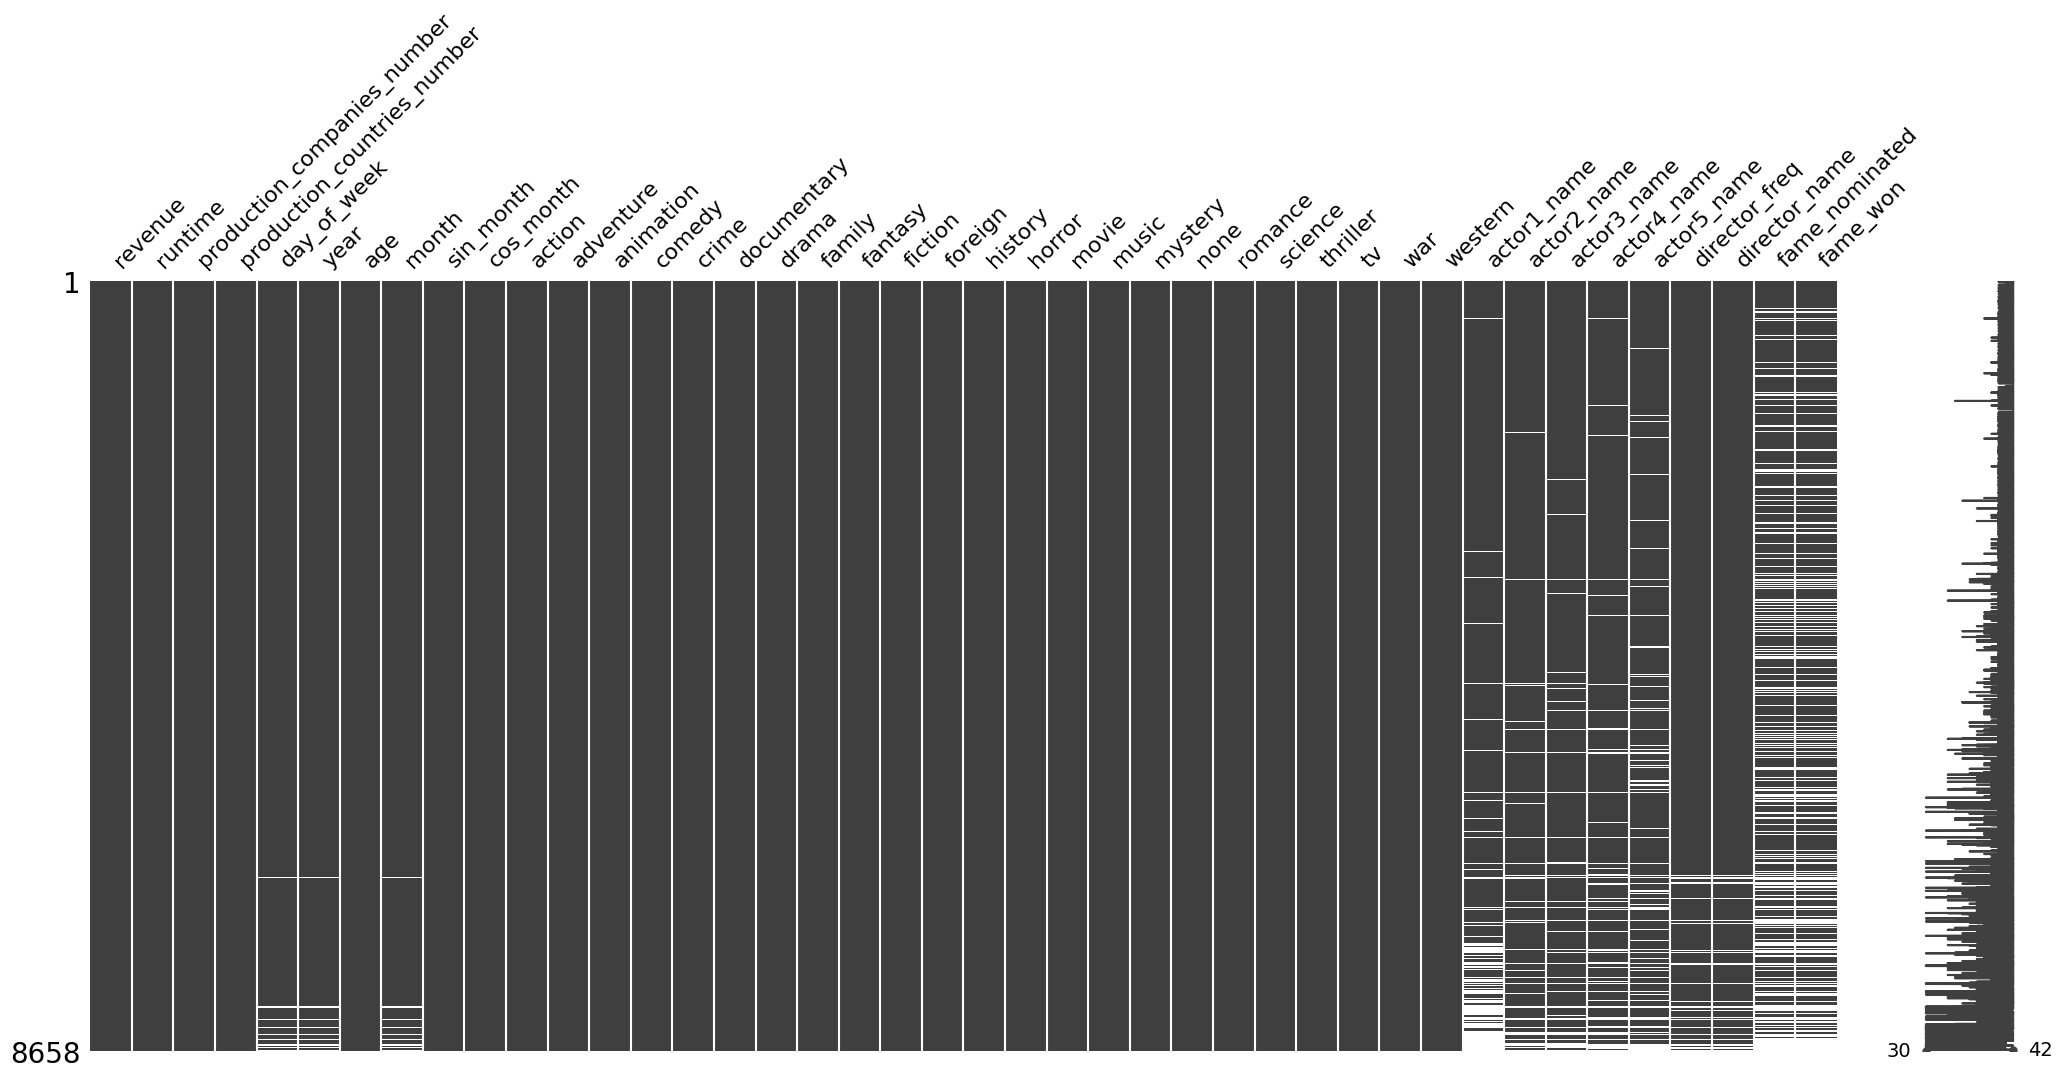

In [60]:
msno.matrix(df)

In [61]:
df.iloc[0]


revenue                             4300000.0
runtime                                  98.0
production_companies_number                 2
production_countries_number                 1
day_of_week                               0.0
year                                   1995.0
age                                      30.0
month                                    12.0
sin_month                                -0.5
cos_month                            0.866025
action                                      0
adventure                                   0
animation                                   0
comedy                                      1
crime                                       1
documentary                                 0
drama                                       0
family                                      0
fantasy                                     0
fiction                                     0
foreign                                     0
history                           